## Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

## Upvote is the best motivator 👍

# Step 0.0. LightAutoML installation

This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [1]:
!pip install -U lightautoml

     |████████████████████████████████| 262 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 424 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 204 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 19.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 100 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 1.6 MB/s  eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=28e9b7a8b9fe5900bb3a518a08c0da8ece05c745523821029315a790866da912
  

# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.report.report_deco import ReportDeco

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 1800
TARGET_NAME = 'target'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [5]:
%%time

train_data = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
train_data.head()

CPU times: user 18.3 ms, sys: 3.86 ms, total: 22.2 ms
Wall time: 36.6 ms


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [6]:
train_data.shape

(7111, 12)

In [7]:
%%time

test_data = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
test_data.head()

CPU times: user 7.31 ms, sys: 848 µs, total: 8.16 ms
Wall time: 14.2 ms


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [8]:
test_data.shape

(2247, 9)

In [9]:
%%time

sample_sub = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')
sample_sub.head()

CPU times: user 6.32 ms, sys: 863 µs, total: 7.18 ms
Wall time: 14.3 ms


,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0


In [10]:
sample_sub.shape

(2247, 4)

In [11]:
# Pseudolabels from https://www.kaggle.com/mehrankazeminia/2-tps-jul-21-smart-ensembling with public score 0.19009
pseudolabels = pd.read_csv('../input/2-tps-jul-21-smart-ensembling/submission.csv')
pseudolabels

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.536118,4.540027,240.657338
1,2011-01-01 01:00:00,2.035488,7.324082,313.210751
2,2011-01-01 02:00:00,1.819786,7.288144,278.074544
3,2011-01-01 03:00:00,1.919551,8.051587,303.483238
4,2011-01-01 04:00:00,1.361354,6.297477,217.944316
...,...,...,...,...
2242,2011-04-04 10:00:00,2.811722,12.343957,337.776694
2243,2011-04-04 11:00:00,2.342283,10.280946,282.536727
2244,2011-04-04 12:00:00,2.457375,12.470087,280.833718
2245,2011-04-04 13:00:00,2.119895,10.599216,216.085099


In [12]:
for col in ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']:
    test_data[col] = pseudolabels[col]
    
test_data

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1.536118,4.540027,240.657338
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,2.035488,7.324082,313.210751
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1.819786,7.288144,278.074544
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1.919551,8.051587,303.483238
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1.361354,6.297477,217.944316
...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2011-04-04 10:00:00,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,2.811722,12.343957,337.776694
2243,2011-04-04 11:00:00,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,2.342283,10.280946,282.536727
2244,2011-04-04 12:00:00,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,2.457375,12.470087,280.833718
2245,2011-04-04 13:00:00,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,2.119895,10.599216,216.085099


In [13]:
ALL_DF = pd.concat([train_data, test_data]).reset_index(drop = True)
print(ALL_DF.shape)

(9358, 12)


In [14]:
#Small feature engineering part using lags
    
ALL_DF['temperature_lag_3'] = ALL_DF['deg_C'] - ALL_DF['deg_C'].shift(periods=3, fill_value=0)
ALL_DF['temperature_lag_6'] = ALL_DF['deg_C'] - ALL_DF['deg_C'].shift(periods=6, fill_value=0)

ALL_DF['humidity_lag_3'] = ALL_DF['absolute_humidity'] - ALL_DF['absolute_humidity'].shift(periods=3, fill_value=0)
ALL_DF['humidity_lag_6'] = ALL_DF['absolute_humidity'] - ALL_DF['absolute_humidity'].shift(periods=6, fill_value=0)

train_data, test_data = ALL_DF.iloc[:(len(ALL_DF) - len(test_data)), :], ALL_DF.iloc[(len(ALL_DF) - len(test_data)):, :]
print(train_data.shape, test_data.shape)

(7111, 16) (2247, 16)


In [15]:
train_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,temperature_lag_3,temperature_lag_6,humidity_lag_3,humidity_lag_6
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,13.1,13.1,0.7578,0.7578
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,13.2,13.2,0.7255,0.7255
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,12.6,12.6,0.7502,0.7502
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,-2.1,11.0,0.0289,0.7867
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,-1.3,11.9,0.0633,0.7888


# =============== LightAutoML model building ===============


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [16]:
%%time

def rmsle_metric(y_true, y_pred, sample_weight, **kwargs):
    mask = (sample_weight > 1)
    return mean_squared_log_error(y_true[mask], np.clip(y_pred[mask], 0, None), **kwargs) ** 0.5

task = Task('reg', loss = 'rmsle', metric = rmsle_metric, greater_is_better=False)

CPU times: user 141 µs, sys: 28 µs, total: 169 µs
Wall time: 174 µs


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [17]:
?DatetimeRole

Init signature:
DatetimeRole(
    dtype: Union[Callable, type, str] = <class 'numpy.datetime64'>,
    seasonality: Union[Sequence[str], NoneType] = ('y', 'm', 'wd'),
    base_date: bool = False,
    date_format: Union[str, NoneType] = None,
    unit: Union[str, NoneType] = None,
    origin: Union[str, datetime.datetime] = 'unix',
    force_input: bool = False,
    base_feats: bool = True,
    country: Union[str, NoneType] = None,
    prov: Union[str, NoneType] = None,
    state: Union[str, NoneType] = None,
)
Docstring:      Datetime role.
Init docstring:
Create datetime role with specific dtype and attrs.

Args:
    dtype: Variable type.
    seasonality: Seasons to extract from date.
      Valid are: 'y', 'm', 'd', 'wd', 'hour',
      'min', 'sec', 'ms', 'ns'.
    base_date: Base date is used to calculate difference
      with other dates, like `age = report_dt - birth_dt`.
    date_format: Format to parse date.
    unit: The unit of the arg denote the unit, pandas like, see more:
   

In [18]:
%%time

targets_and_drop = {
    'target_carbon_monoxide': ['target_benzene', 'target_nitrogen_oxides'],
    'target_benzene': ['target_carbon_monoxide', 'target_nitrogen_oxides'],
    'target_nitrogen_oxides': ['target_carbon_monoxide', 'target_benzene']
}

roles = {
    # delete day of month from features
    DatetimeRole(base_date=False, base_feats=True, seasonality=('d', 'wd', 'hour')): 'date_time'
}

CPU times: user 34 µs, sys: 7 µs, total: 41 µs
Wall time: 45.5 µs


In [19]:
ALL_DF['weight'] = [1.001] * (len(ALL_DF) - len(test_data)) + [0.999] * len(test_data)
roles['weights'] = 'weight'

# Step 3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:70%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - we use `use_algos` key to setup the model structure to work with (two LGBM models and two CatBoost models on the first level and their weighted composition creation on the second). This setup is only to speedup the kernel, you can remove this `general_params` setup if you want the whole LightAutoML model to run.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936). 

In [20]:
%%time 
importances = {}
dt = pd.to_datetime(ALL_DF['date_time'])
for targ in targets_and_drop:
    print('='*50, '='*50, sep = '\n')
    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                           general_params={'use_algos': [['lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
                          )

    roles['target'] = targ
    roles['drop'] = targets_and_drop[targ]

    if targ == 'target_nitrogen_oxides':
        oof_pred = automl.fit_predict(ALL_DF[dt >= np.datetime64('2010-09-01')], roles = roles)
    else:
        oof_pred = automl.fit_predict(ALL_DF, roles = roles)
    print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))
    
    # Fast feature importances calculation
    fast_fi = automl.get_feature_scores('fast')
    importances[targ] = fast_fi
    
    test_pred = automl.predict(test_data)
    print('Prediction for te_data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))
    
    sample_sub[targ] = np.clip(test_pred.data[:, 0], 0, None)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (9358, 17)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1772.5164513587952 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0404724	valid's Opt metric: 0.210814
[200]	valid's l2: 0.0171239	valid's Opt metric: 0.143343
[300]	valid's l2: 0.0123362	valid's Opt metric: 0.124347
[400]	valid's l2: 0.0106542	valid's Opt metric: 0.116071
[500]	valid's l2: 0.00970044	valid's Opt metric: 0.110776
[600]	valid's l2: 0.00920816	valid's Opt metric: 0.107995
[700]	valid's l2: 0.00893539	valid's Opt metric: 0.106401
[800]	valid's l2: 0.00875229	valid's Opt metric: 0.105332
[900]	valid's l2: 0.0086123	valid's Opt metric: 0.1045
[1000]	valid's l2: 0.00852205	valid's Opt metric: 0.103971
[1100]	valid's l2

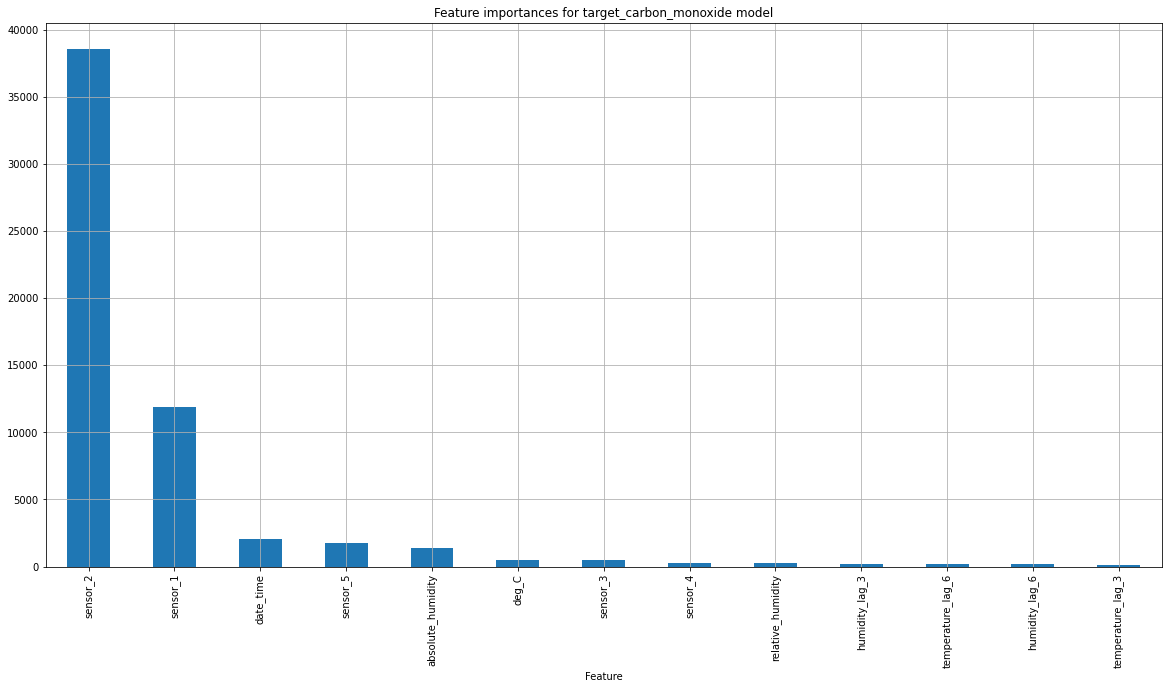

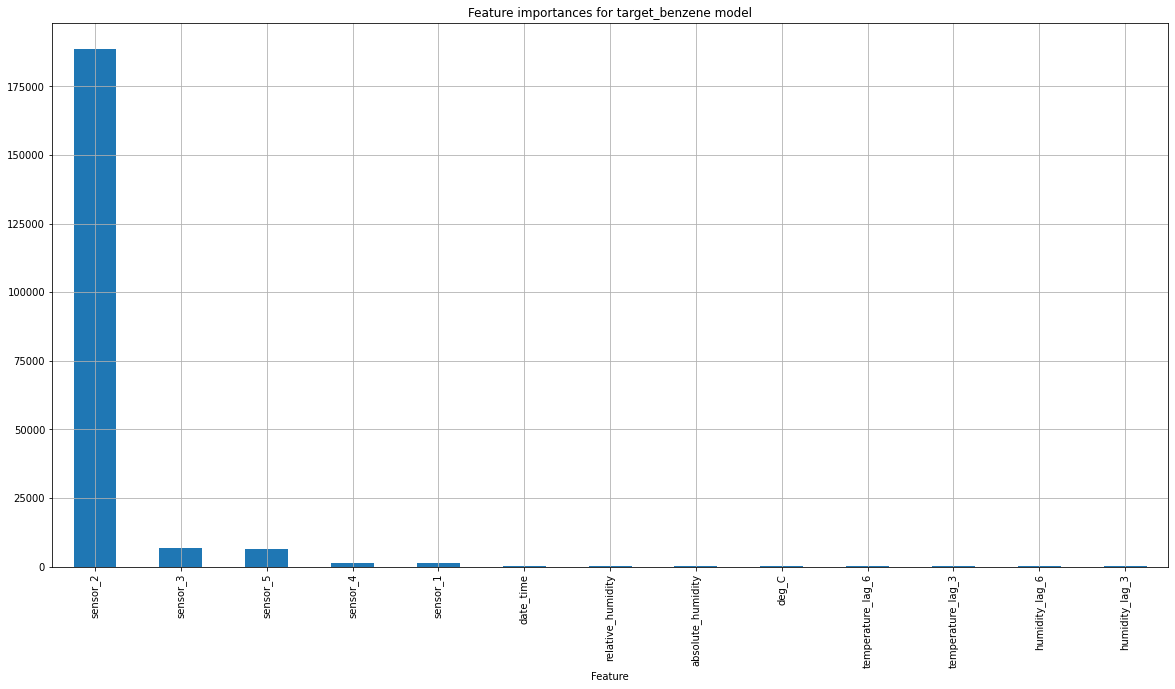

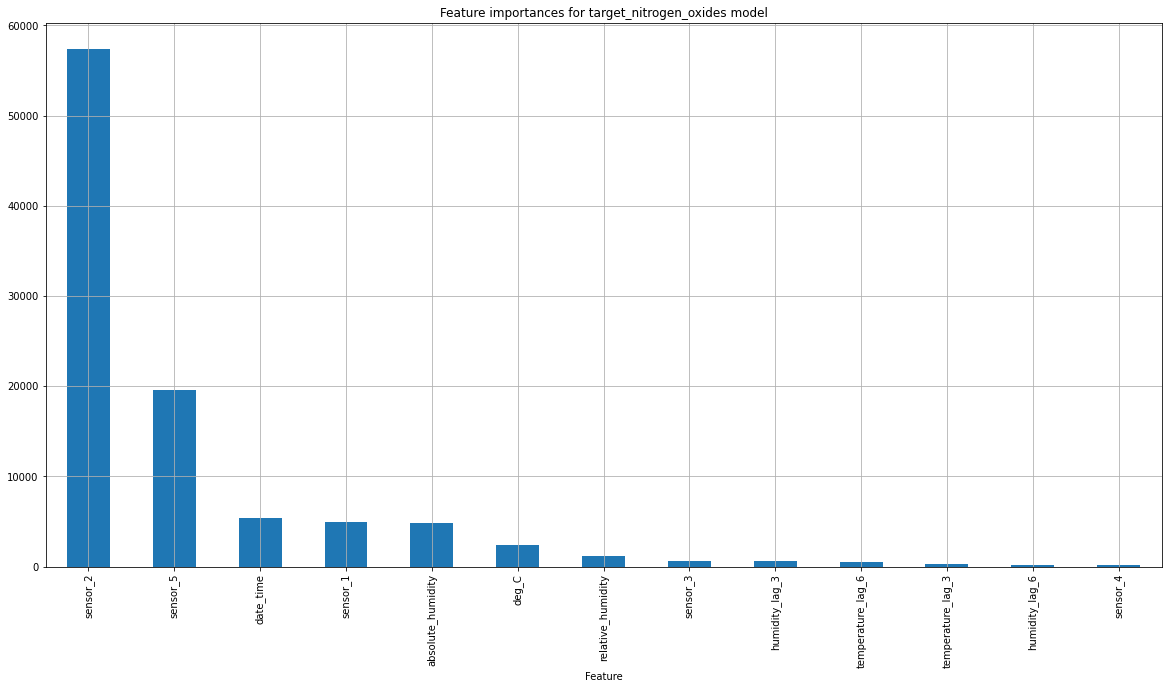

In [21]:
for targ in targets_and_drop:
    plt.figure(figsize = (20, 10))
    importances[targ].set_index('Feature')['Importance'].plot.bar()
    plt.title('Feature importances for {} model'.format(targ))
    plt.grid(True)
    plt.show()

# Step 4. Create submission file

In [22]:
sample_sub

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.545027,4.762195,222.209152
1,2011-01-01 01:00:00,2.039234,7.312765,307.577515
2,2011-01-01 02:00:00,1.803894,7.321136,273.408112
3,2011-01-01 03:00:00,1.883722,7.955687,298.324554
4,2011-01-01 04:00:00,1.328905,6.118501,219.891434
...,...,...,...,...
2242,2011-04-04 10:00:00,2.774520,12.404977,333.103424
2243,2011-04-04 11:00:00,2.313617,10.403061,281.427979
2244,2011-04-04 12:00:00,2.455640,12.507922,285.925537
2245,2011-04-04 13:00:00,2.079191,10.519443,213.701157


In [23]:
sample_sub.to_csv('lightautoml_with_pseudolabelling_kernel_version_6.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [Pseudolabelling technique description post](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738#1268903)
- [Baseline LightAutoML kernel without pseudolabelling](https://www.kaggle.com/alexryzhkov/tps-july-21-lightautoml-baseline)

## Do not forget to upvote if you like the kernel 👍